In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
#%matplotlib notebook

import matplotlib.pyplot as plt 
import datetime as dt
import matplotlib.dates as mdates
from scipy import stats as st

import math as mth

# Игры 
## Формирование модели монетизации

У нас есть данные по мобильной игре **"Космические братья"** в ней пользователь строит свою космическую программу пытаются преуспеть нелёгком деле канализации галактикеи.У нас представлены данные по игре пользователя на первом уровне.
Пользователь может завершить игру выполнив одно из двух условий:
* победа над первым врагом 
* реализация проекта разработка орбитальной сборки спутников 

**у нас есть данные по когорте пользователей с 4 по 10 мая включительно.**

### Задача

**Сформировать модель монетизации мобильной игры «Космические братья».**

0. [Данные - предобработка](#step0) 
    >* проверить пропуски и битые данные
    >* разделить пользователей по виду прохождения игры и платформам привелечения
    
1. [Внешняя подгрузка данных](#step1) 
    >* загрузить данные о стоимости рекламы в приложении и форматах рекламы
    
2. [Прохождение первого игрового уровня](#step2)
    >* смотрим метрики - DAU, Retention
    >* cреднее время прохождения уровня
    >* частота заходов
    >* заходы по дням - накопительные
    >* статистическая гипотеза - посчитаем статистическую значимость времени прохождение уровня между пользователями которые заканчивают уровень через разные типы сценария.

3. [Экономика игры](#step3)
    >* конверсия по каналам привелечения
    >* CPI 
    >* разрабоать модель, которая приведет к окупаемости вложений в рекламу

    
4. [Презентация](#step4) 
5. [Выводы](#step5) 


##  Загрузим данные и подготовим к анализу <a id="step0"></a>

In [2]:
ad_cost =  pd.read_csv('https://docs.google.com/spreadsheets/d/1O4pDRqoS-b7ezYWDBy9cYWO5jeu1ULyd0OTU1Ab6deo/export?format=csv')
print(ad_cost.info())
ad_cost.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
None


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [3]:
user =  pd.read_csv('https://docs.google.com/spreadsheets/d/1f48Bzk1gezh20kISERPdGXb5f_df8tbBldz4Egaf_Q4/export?format=csv')
print('Количество дубликатов - ', user.duplicated().sum())
print(user.info())
user.head(5)

Количество дубликатов -  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB
None


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [4]:
data =  pd.read_csv('https://docs.google.com/spreadsheets/d/1kGNgRnWCvUTA0osQMZCjOvZnXPv164K1gqEEER4nK28/export?format=csv')#.fillna(0)
print('Количество дубликатов - ', data.duplicated().sum())
data = data.drop_duplicates().drop(['project_type'], axis='columns')
print(data.info())
data.head(5)

Количество дубликатов -  1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 4 columns):
event_datetime    135639 non-null object
event             135639 non-null object
building_type     127956 non-null object
user_id           135639 non-null object
dtypes: object(4)
memory usage: 5.2+ MB
None


,event_datetime,event,building_type,user_id
0,2020-05-04 0:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de
1,2020-05-04 0:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347
2,2020-05-04 0:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710
3,2020-05-04 0:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c
4,2020-05-04 0:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d


Почти все данные по пользователям у нас полные - не хватает даннных по постройке - project_type , но этот столбец нам и не нужен, так как мы имеем данные только за 1 уровень, который он и отражает. building_type - не полные данные, потому что пользователи которые прошли уровень победой - не занимались строительством. Так же переведем все время в правильный формат. 

Посмотрим, как часто встеречаются определенные события, и какие постройки строят чаще всего

In [5]:
data['event'].value_counts()

building            127956
finished_stage_1      5817
project               1866
Name: event, dtype: int64

In [6]:
data['building_type'].value_counts()

spaceport          59325
assembly_shop      54494
research_center    14137
Name: building_type, dtype: int64

Мы видим что всего закончило первый уровень 5817 пользователей, из них завершили уровень постройкой проекта - 1866 пользователей чаще всего строили spaceport и assembly_shop. research_center строился менее всего

### Создадим списки пользователей по типам проходжения / не прохождения - ушел, побeдил, построил

In [7]:
data['sup_events'] = data['event'].where(data['event'] != 'building', 0)
project_user = data.query('sup_events != 0 and event =="project"')['user_id'].unique().tolist() # построили

win_user = data[~data.user_id.isin(project_user)].query('sup_events != 0')['user_id'].unique().tolist() #победили

out_user = data.query('sup_events == 0 and user_id != @project_user and user_id != @win_user')['user_id'].\
                unique().tolist() # не дошли до конца


Создадим столбец win - чтобы показать там к какой группе относиться пользователь.

In [8]:
data.loc[data.user_id.isin(out_user), 'win'] = 0 # ушли
data.loc[data.user_id.isin(project_user), 'win'] = 1 # построили
data.loc[data.user_id.isin(win_user), 'win'] = 2 # победили врага
data.head(5)

,event_datetime,event,building_type,user_id,sup_events,win
0,2020-05-04 0:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,0,0.0
1,2020-05-04 0:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,0,1.0
2,2020-05-04 0:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,0,2.0
3,2020-05-04 0:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,0,0.0
4,2020-05-04 0:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,0,2.0


Соеденим пользователя с его каналом захода на сайт.

In [9]:
data = data.merge(user, on= 'user_id', how ='left')

### Посмотрим максимальные значения - когда какой обьект был построен, чтобы понимать динамику прохождения уровня пользователем. 

In [10]:
bild = data.query('event == "building"').\
            pivot_table(index = 'user_id', columns = 'building_type', values = 'event_datetime',aggfunc = 'max')
# отфарматируем столбцы со временем
bild['assembly_shop'] = pd.to_datetime(bild['assembly_shop'])
bild['research_center'] = pd.to_datetime(bild['research_center'])
bild['spaceport'] = pd.to_datetime(bild['spaceport'])


In [11]:
def create(df):
    assembly_shop = df['assembly_shop']
    spaceport = df['spaceport']
    if assembly_shop > spaceport:
        return assembly_shop - spaceport
    else:
        return spaceport - assembly_shop
bild = bild.assign(second = lambda x: x.apply(create, axis=1)).\
            assign(third = lambda x: x['research_center'] - x['assembly_shop'])


Добавим временные события - first_datetime, last_datetime. А так же day_event - которые явлется разницей события и первого захоа пользователя.

In [12]:
data['event_datetime'] = pd.to_datetime(data['event_datetime'])
min_visit = data.groupby(['user_id']).agg(first_datetime = ('event_datetime','min'))
max_visit = data.groupby(['user_id']).agg(last_datetime = ('event_datetime','max'))

data = data.merge(min_visit, on = 'user_id')
data = data.merge(max_visit, on = 'user_id')

data['day_event'] = data['event_datetime'] -data['first_datetime'] 
data['day_event'] = data['day_event'] / np.timedelta64(1,'D')
data['day_event'] = data['day_event'].round().astype('int')
#data.loc[data['day_event']==0, 'day_event'] = 1

data.head(3)

,event_datetime,event,building_type,user_id,sup_events,win,source,first_datetime,last_datetime,day_event
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,0,0.0,youtube_channel_reklama,2020-05-04 00:00:01,2020-05-10 20:27:01,0
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,0,0.0,youtube_channel_reklama,2020-05-04 00:00:01,2020-05-10 20:27:01,1
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,0,0.0,youtube_channel_reklama,2020-05-04 00:00:01,2020-05-10 20:27:01,2


Добавим для каждого пользователя - стоимость его привлечения.


Цена клика в наших данных - на день раньше от захода - поэтому помениием его на +1 чтобы правильно распределить по пользователям.
в дальнейшем при работе с такими данными - нужно использовать сквозную аналитику чтобы сразу видеть канал привлечения пользователя

In [13]:
ad_cost['day'] = pd.to_datetime(ad_cost['day'])
ad_cost['ferst_visit_day'] = ad_cost['day'].dt.day
ad_cost['ferst_visit_day'] = ad_cost['ferst_visit_day'] + 1
ad_cost = ad_cost[['source','cost','ferst_visit_day']]

data['ferst_visit_day'] = data['first_datetime'].dt.day
cost = data.groupby(['ferst_visit_day', 'source']).agg(kol = ('user_id','nunique')).reset_index()
cost = cost.merge(ad_cost, on = ['source','ferst_visit_day'])
cost['user_cena']= cost['cost']/cost['kol']
cost = cost[['source','user_cena','ferst_visit_day']]


data = data.merge(cost, on = ['source','ferst_visit_day'])
data.head(3)

,event_datetime,event,building_type,user_id,sup_events,win,source,first_datetime,last_datetime,day_event,ferst_visit_day,user_cena
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,0,0.0,youtube_channel_reklama,2020-05-04 00:00:01,2020-05-10 20:27:01,0,4,0.396357
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,0,0.0,youtube_channel_reklama,2020-05-04 00:00:01,2020-05-10 20:27:01,1,4,0.396357
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,0,0.0,youtube_channel_reklama,2020-05-04 00:00:01,2020-05-10 20:27:01,2,4,0.396357


Привяжем эти данные к каждому пользователю

In [14]:
table = data.query('sup_events ==0')[['user_id','first_datetime','last_datetime','win','source','user_cena']].drop_duplicates().copy()
table = table.merge(bild, on= 'user_id', how ='left')

def create_f(df):
    assembly_shop = df['assembly_shop']
    spaceport = df['spaceport']
    first_datetime = df['first_datetime']
    if assembly_shop > spaceport:
        return spaceport - first_datetime
    else:
        return assembly_shop - first_datetime
table = table.assign(first = lambda x: x.apply(create_f, axis=1))
table.head(3)

,user_id,first_datetime,last_datetime,win,source,user_cena,assembly_shop,research_center,spaceport,second,third,first
0,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04 00:00:01,2020-05-10 20:27:01,0.0,youtube_channel_reklama,0.396357,2020-05-10 20:27:01,NaT,NaT,NaT,NaT,6 days 20:27:00
1,fa352362-d258-472c-b295-2796ccc39fa3,2020-05-04 00:01:33,2020-05-19 14:36:02,1.0,youtube_channel_reklama,0.396357,2020-05-09 11:03:00,2020-05-16 12:18:31,2020-05-19 07:56:23,9 days 20:53:23,7 days 01:15:31,5 days 11:01:27
2,7e7d2d26-156e-4fd6-aebf-4df91181c9a4,2020-05-04 00:04:47,2020-05-09 18:07:15,0.0,youtube_channel_reklama,0.396357,2020-05-09 18:07:15,2020-05-08 12:09:35,2020-05-05 05:12:36,4 days 12:54:39,-2 days +18:02:20,1 days 05:07:49


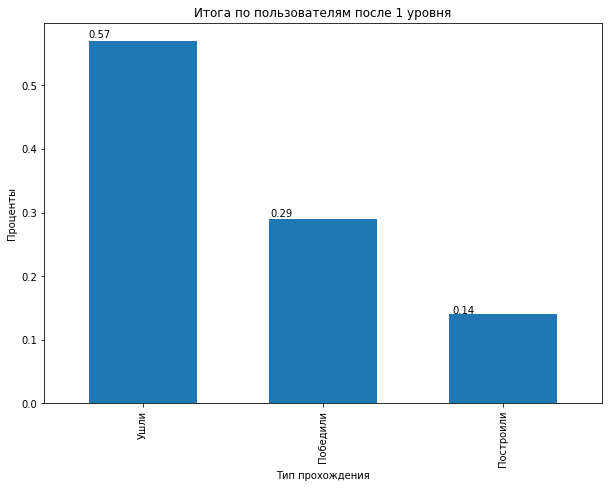

In [61]:
ss = table['win'].value_counts().to_frame().assign(proc = lambda x: (x['win'] / 13576).round(2)).T
ss.columns=['Ушли','Победили','Построили']
ss =ss.T
ax = ss['proc'].plot(kind = 'bar',figsize=(10, 7),width = 0.6)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() * 1.01, p.get_height() * 1.01))
    
plt.title('Итога по пользователям после 1 уровня')
plt.ylabel('Проценты')
plt.xlabel('Тип прохождения')
plt.show()

Мы видим к сожалению, что 7759 пользователей не дошло до конца первого уровня и покинул игру. 3151 пользователи прошли уровень победив врага и 1866 пользователей прошли первый уровень с помощью постройки орбитальной станции

##  Внешняя подгрузка данных<a id="step1"></a>

Мы планируем зарабатывать на показах рекламы в нашем приложении, чтобы понять сколько минимум нам нужно заработать чтобы отбить затраты по пользователям - узнаем сколько принесет нам реклама. 
Обратим внимание на показатель eCPM — показатель эффективности стоимости за тысячу показов. В СНГ этот показатель для AdMob колеблется в пределах $0,5-$2. Т.е. за 1000 показов рекламы наше приложение заработает $0,5.

Источник: https://woxapp.com/ru/our-blog/monetize-mobile-applications/

## Прохождение первого игрового уровня <a id="step2"></a>

Посмотрим DAU

In [16]:
data['day_event_data']= data['event_datetime'].astype('datetime64[D]')

In [17]:
dau_total = data.groupby('day_event_data').agg({'user_id': 'nunique'})
print('Количество уникальных пользователей в день в среднем', int(dau_total.mean()))
#dau_total.plot()

Количество уникальных пользователей в день в среднем 2884


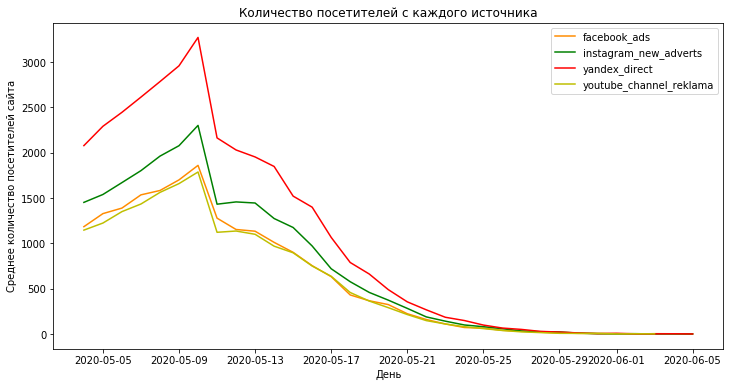

In [18]:
dau = data.groupby(['day_event_data', 'source']).agg(user_id = ('user_id','nunique'))\
            .reset_index().pivot_table(index = 'day_event_data', columns ='source', values = 'user_id').reset_index()
x = dau['day_event_data'].tolist()
y1 = dau['facebook_ads'].tolist()
y2 = dau['instagram_new_adverts'].tolist()
y3 = dau['yandex_direct'].tolist()
y4 = dau['youtube_channel_reklama'].tolist()
fig, ax = plt.subplots()

ax.plot(x, y1,  color="#FF8C00", label = 'facebook_ads')
ax.plot(x, y2, 'g', label = 'instagram_new_adverts')
ax.plot(x, y3,  'r', label = 'yandex_direct')
ax.plot(x, y4, 'y', label = 'youtube_channel_reklama')   

ax.legend()
plt.xlabel('День')
plt.ylabel('Среднее количество посетителей сайта')
plt.title('Количество посетителей с каждого источника')
fig.set_figheight(6)
fig.set_figwidth(12)
plt.show()

Наибольшее количество активных пользователей нам приносит yandex_direct на втором месте Инстаграм. Youtube Facebook делят третье четвёртое место

### Как часто люди возвращаются?

Посчитаем Retention 

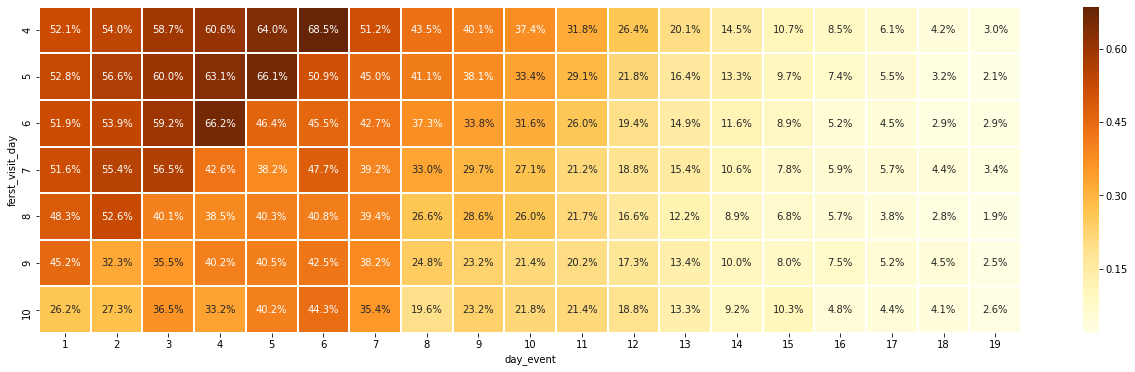

In [19]:
data['ferst_visit_day'] = data['first_datetime'].dt.day
# сгруппируем по 1 месяцу и lifetime и посчитаем уникальное количество пользователей 
cohorts = data.groupby(['ferst_visit_day','day_event']).agg({'user_id':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['day_event'] == 0][['ferst_visit_day','user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='ferst_visit_day')
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']

# уберем из тепловой карты 1 месяц 
cohorts = cohorts.query('0 < day_event < 20')

#сформируем сводную таблицу по когортам
retention_pivot = cohorts.pivot_table(index='ferst_visit_day',columns='day_event',values='retention',aggfunc='sum')
#retention_pivot.index = retention_pivot.index.strftime("%m/%Y")
plt.figure(figsize=(22, 6))

#построим тепловую карту
#plt.title('Коэффициент удержания')
sns.heatmap(retention_pivot, cmap='YlOrBr',annot=True, fmt='.1%', linewidths=1, linecolor='white')
#plt.show()

Наша игра интересная, в течении недели - практически половина пользователей остаеться в игре. И вероятно те, кто прошел первый уровень пойдут дальше.

### Среднее время прохождения уровня

Для каждой группы пользователей посмотрим их среднее время на уровне.

**Гипотеза:**  Проверим , что среднее время прохождения уровня для пользователей не отличается, в не зависимости от типа прохождения.

In [20]:
table['all_time'] = table['last_datetime'] -table['first_datetime'] 
table['all_time'] = table['all_time'] / np.timedelta64(1,'D')
table['all_time'] = table['all_time'].round().astype('int')
box = table.groupby(['win','user_id'])['all_time'].max().reset_index()

In [21]:
sample_1 = box.query("win == 1.0")['all_time'].tolist()
sample_2 = box.query("win == 2.0")['all_time'].tolist()

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Среднее время прохождения уровня между теми кто строил и теми кто побеждал - отличается")
else:
    print("Среднее время прохождения уровня между теми кто строил и теми кто побеждал - одинаково.")

p-значение: 9.631515322512218e-98
Среднее время прохождения уровня между теми кто строил и теми кто побеждал - отличается


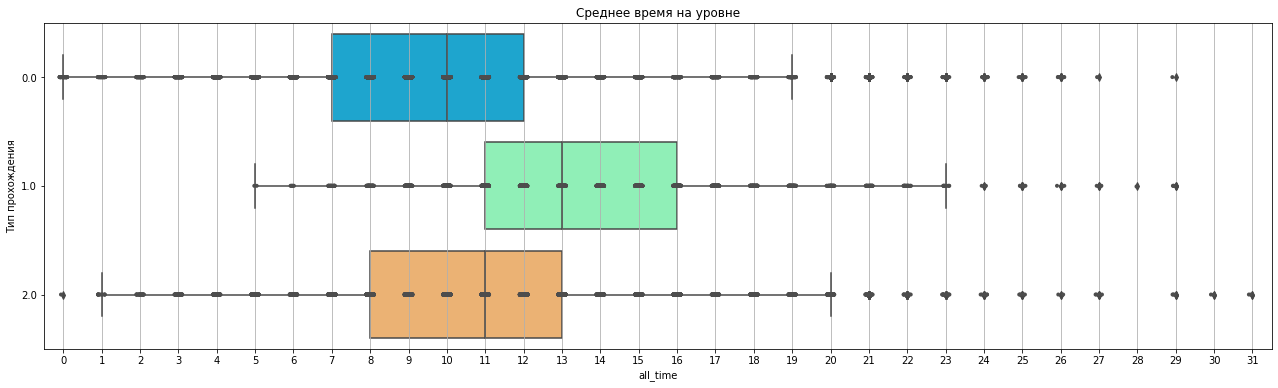

In [22]:
f, ax = plt.subplots(figsize=(22, 6))
sns.boxplot(x="all_time", y="win", data=box, palette='rainbow', orient='h');

sns.stripplot(x="all_time", y="win", data=box,size=4, color=".3", linewidth=0)

ax.set_title("Среднее время на уровне")
plt.ylabel('Тип прохождения')
ax.xaxis.grid(True)


Получается что тот кто не прошел уровень уходит до 10 дня. В среднем те кто побеждает врага - тип прохождения 2-  стараются тоже пройти быстрее - размах их завершений от 1 до 20 дней. В среднем их в среднем они проходят уровень за 11 дней.

Те кто строит проходит в среднем уровень за 13 дней, но также размах их завершения уровня от 5 до 23 дней То есть получается что постройки занимают наибольшее количество времени для прохождения уровня

**Проверим гипотезу - вторую:** Количество событий на пользователя не отличается в не зависимости от типа прохождения.

In [80]:
box2= data.groupby(['win','user_id'])['event'].count().reset_index()


sample_12 = box2.query("win == 1.0")['event'].tolist()
sample_22 = box2.query("win == 2.0")['event'].tolist()

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_12, 
    sample_22)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Количество событий у пользователей по разному проходивших - отличается")
else:
    print("Количество событий у пользователей по разному проходивших- одинаково.")

p-значение: 0.0
Количество событий у пользователей по разному проходивших - отличается


Посмотрим график - количество событий на пользователя.

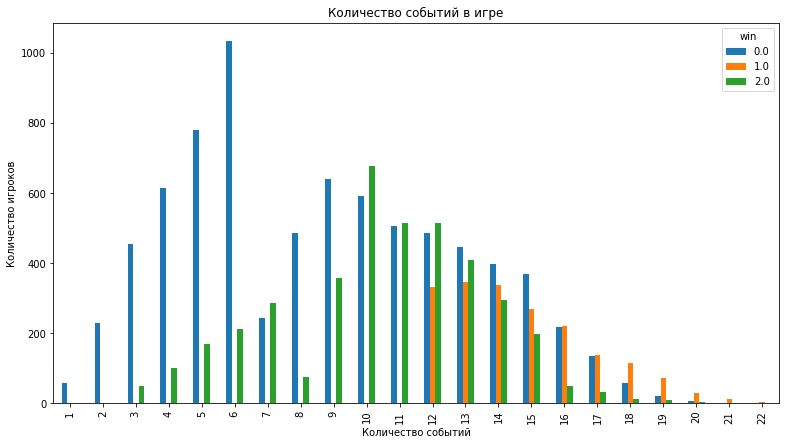

In [92]:
box2.pivot_table(index = 'event', columns = 'win', values ='user_id', aggfunc = 'count').plot(kind = 'bar',figsize=(13,7))
plt.title('Количество событий в игре')
plt.ylabel('Количество игроков')
plt.xlabel('Количество событий')
plt.show()

Мы видим что очень большое количество игроков которые ушли из игры отваливаются после шестого события в игре быть может это какой-то Баг и надо посмотреть не был ли в этом месте каких-либо проблем в интерфейсе игры если проблем нет тогда можно на этом месте давать игроку какую-то помощь, подсказку либо возвращать их в игру с помощью push-уведомлений

### Посмотрим как часто заходят пользователи из разных групп

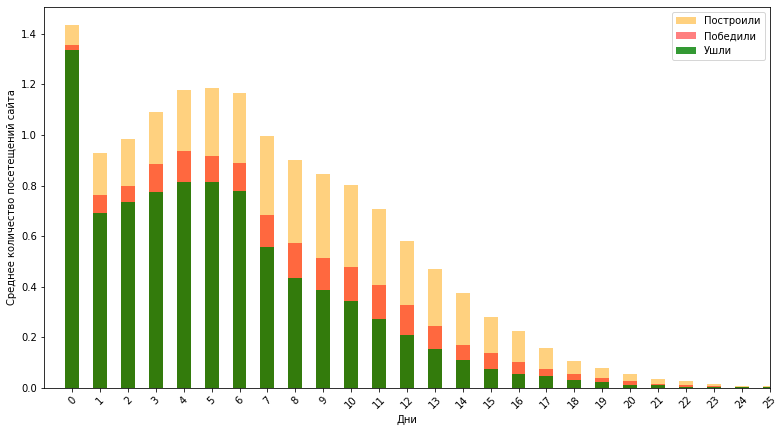

In [23]:
plt.figure(figsize=(13,7))

data.query('win == 1').\
        pivot_table(index = 'user_id', columns = 'day_event',values = 'event',aggfunc = 'count'
                                                         ).fillna(0).apply(np.mean, axis=0).\
                plot(kind = 'bar',color = 'orange',alpha= 0.5, label = 'Построили')
data.query('win == 2').\
        pivot_table(index = 'user_id', columns = 'day_event',values = 'event',aggfunc = 'count'
                                                         ).fillna(0).apply(np.mean, axis=0).\
                        plot(kind = 'bar', color = 'red',alpha= 0.5, label = 'Победили')
data.query('win == 0').\
        pivot_table(index = 'user_id', columns = 'day_event',values = 'event',aggfunc = 'count'
                                                         ).fillna(0).apply(np.mean, axis=0).\
                                            plot(kind = 'bar', color = 'green',alpha= 0.8, label = 'Ушли')
#ax = plt.subplots()
plt.legend()
plt.xlabel('Дни')
plt.ylabel('Среднее количество посетещений сайта')
plt.xticks(rotation=45) # поворот текста в графике
#plt.ylim([0,2]) # размеры графика по осям
plt.xlim([-1,25]) # размеры графика по осям

plt.show()

Очевидно, что те кто строит заходит в игру чаще в среднем раз в день - на активном этапе строительства. Ушедшие пользователи явно реже и мы видим спад после седьмого дня. Те кто победил не хотят много времени тратить на строительство, сремятся быстрее закончить и также на седьмой день мы видим спад заходов.

### Как часто пользователь приходит при разных сценариях игры - на одну постройку.

In [24]:
tr = data.pivot_table(index = ['win','user_id'], columns = 'building_type', values = 'event',aggfunc = 'count').\
                reset_index().fillna(0).drop(['user_id'], axis='columns')
tr.groupby(['win']).mean()

building_type,assembly_shop,research_center,spaceport
win,,,
0.0,3.747906,0.861580,4.047558
1.0,4.885316,1.981243,5.781350
2.0,4.125032,0.950392,4.336117


### Заходы по дням - накопительные

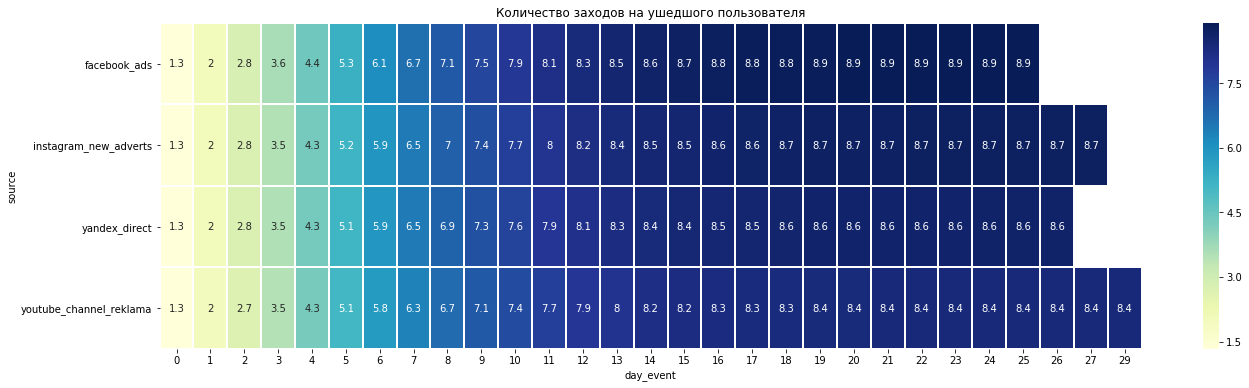

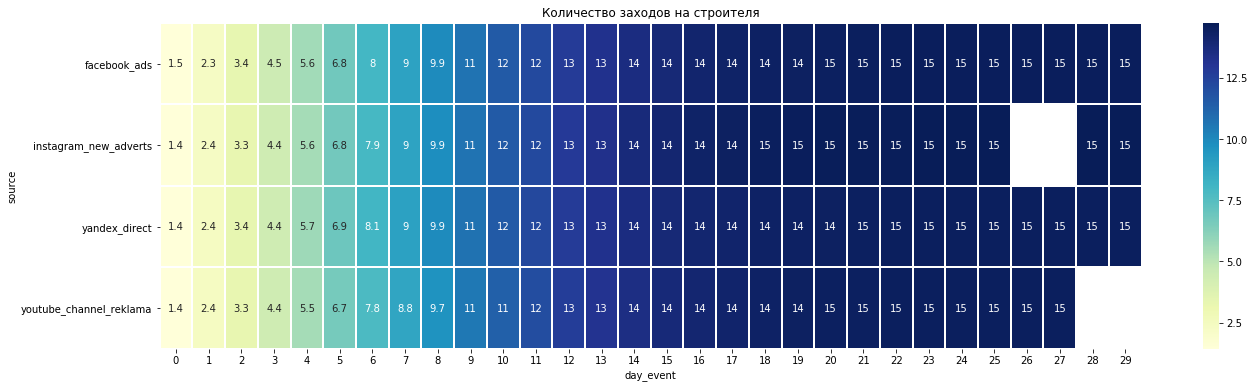

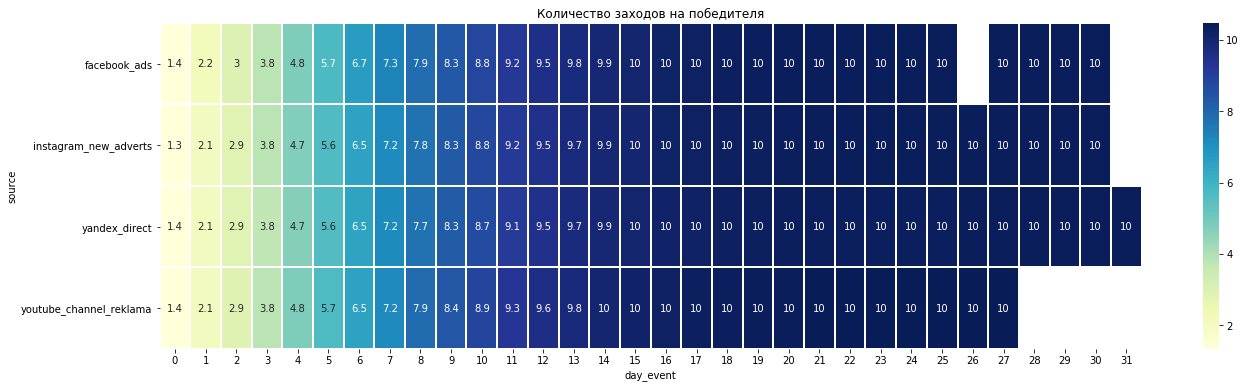

In [25]:
for znach in data['win'].unique():
    srez = data.loc[data['win'] == znach].copy()
    byer = srez.groupby('source').agg(uid_count =('user_id', 'nunique')).reset_index()

    nakop = srez.merge(byer, on = 'source')

    one_byer = nakop.groupby(['source','day_event']).\
                agg(byer_count=('uid_count','max'), revenue_count =('user_id', 'count')).reset_index().\
                assign(one_byer = lambda x: x['revenue_count'] / x['byer_count'])

    one = one_byer.pivot_table(
            index='source', 
            columns='day_event', 
            values='one_byer')
    one
    plt.figure(figsize=(22, 6))
    sl = {0.0:'ушедшого пользователя', 1.0:'строителя', 2.0:'победителя'}
    sm = sl[znach]
    plt.title('Количество заходов на '+ str(sm))
    sns.heatmap(one.cumsum(axis=1), annot=True,  fmt = '.2g', cmap="YlGnBu", linewidths=1, linecolor='white')
    plt.show()

### Выводы по прохождению:

По каналам не очень большая разница в количестве заходов игры разве что пользы для из канала Фэйсбук ушедшие показывают чуть больше заходов чем пользователей из канала YouTube но не критично. На во всех остальных каналах пользователя ведут себя примерно одинаково в независимсоти от канала привлечения.

Ушедший пользователя который покидает игру на десятый день в среднем приносит нам от 7 до 7.4 захода в игру в зависимости от канала привлечения.

Пользователь который проходит уровень через строительство и заканчивается в среднем на 13 день посещает игру в среднем 13 раз Пользователь, который проходит игру через победу над врагом посещает только в среднем 11 дней заканчивает уровень 9 раз.

**Я предлагаю на 10 день игры - давать пользователю бонус - быстрое строительство космодрома, либо еще какие либо блага - чтобы удержать его в игре, чтобы повысить вовлеченность и избежать оттока**.


## Экономика игры  <a id="step3"></a>

### Посчитаем  различия в конверсии между группами пришедших с разных каналов

In [26]:
t_user = table.groupby(['source','win']).agg(user_id = ('user_id','nunique')).\
            pivot_table(index = 'source' ,columns = 'win', values = 'user_id').reset_index().rename({0.0: 'out'}, axis='columns').\
            assign(win = lambda x: x[1.0] + x[2.0]).assign(alll = lambda x: x['out'] + x['win'])

t_cena = table.groupby(['source','win']).agg(user_cena = ('user_cena','sum')).\
            pivot_table(index = 'source' ,columns = 'win', values = 'user_cena').reset_index().rename({0.0: 'out_cena'}, axis='columns').\
            assign(win_cena = lambda x: x[1.0] + x[2.0])
t_cena = t_cena.merge(t_user, on = 'source')[['source','out_cena','out','win_cena','win']]

t_user[['source','win','alll']].assign(convers = lambda x: x['win'] / x['alll']*100)

win,source,win,alll,convers
0,facebook_ads,1150,2726,42.186354
1,instagram_new_adverts,1466,3347,43.800418
2,yandex_direct,2042,4817,42.391530
3,youtube_channel_reklama,1159,2686,43.149665


Конверсия по всем каналам приблизительно одинаковая и составляет 42- 43 процента.

### Посчитаем CPI ( по всем пользователям, без разделения на каналы)

In [27]:
print('CPI игры в среднем,',ad_cost['cost'].sum() / user['user_id'].count())

CPI игры в среднем, 0.5600749106355349


Посчитаем CPI -  реальную цену за установку приложения на смартфон или планшет, по каждому каналу отдельно

In [28]:
t_cena['CPI'] = (t_cena['out_cena']+t_cena['win_cena']) / (t_cena['win']+ t_cena['out'])
t_cena[['source','CPI']]

win,source,CPI
0,facebook_ads,0.785365
1,instagram_new_adverts,0.645785
2,yandex_direct,0.463590
3,youtube_channel_reklama,0.397662


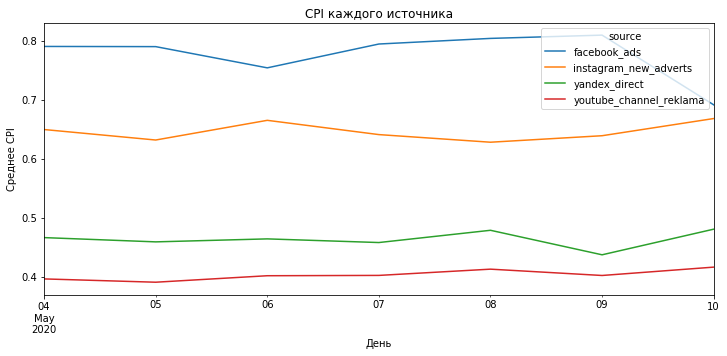

In [29]:

table['first_date']= table['first_datetime'].astype('datetime64[D]')
table.pivot_table(index = 'first_date', columns = 'source', values = 'user_cena').plot(figsize=(12,5))
#ax.legend()
plt.xlabel('День')
plt.ylabel('Среднее CPI')
plt.title('CPI каждого источника')
fig.set_figheight(6)
fig.set_figwidth(12)
plt.show()

Мы видим два канала которые приносят нам пользователей по наименьшей цене - youtube_channel_reklama и как ни странно yandex_direct. Их CPI равна 0.397662 и 0.463590, соответственно. 

Посчитаем, сколько всего видители пользователи нашей когорты предлежение построить обьект, и сколько мы сможем заработать показывая рекламу всем кто играет - в момент выбора постройки.

In [30]:
strr = (bild['assembly_shop'].count() + bild['research_center'].count() + bild['spaceport'].count())/1000*0.5
print('Сколько заработаем на пользователях, если будем показывать рекламу только при выборе обьекта постройки-', strr)

print('Вложения в рекламу для привелечения пользователей -', ad_cost['cost'].sum().round())

Сколько заработаем на пользователях, если будем показывать рекламу только при выборе обьекта постройки- 17.239
Вложения в рекламу для привелечения пользователей - 7604.0


## Выводы по экономике трафика:

По нашим рекламным каналам мы видим что наши вложения в рекламу по привлечению пользователей существенно больше количества денег которые можно заработать при показе рекламы только при выборе постройки.Если мы покажем рекламу всем пользователям то сможем заработать лишь -  17 единиц относительно 7603 которым подарили на привлечение этих пользователей.

Также мы видим что CPI  2 каналов очень высоко и составляет 0.78 для Facebook и  0.64 для Инстаграма.

И все равно получается не рентабельно. платим мы за привлечение пользователя 0,39 в лучшем случае. То есть нам надо показать рекламу ему 780 раз! чтобы окупить его привлечение.

**Я предлагаю отключить этих два канала или провести модернизацию рекламной кампании в данный момент использовать для привлечения пользователей канала YouTube и Яндекс директа**.

## Выводы

### Рассмотреть другие способы увеличить количество рекламы в игре: 

* показ рекламы при каждом заходе пользователя.
* выплата валюты за просмотр рекламы.
* пропуск времени на окончание действий - в нашем случае на постройку обьекта, пользователь платит за ускорение строительства.
* покупка спец. возможностей - улучшенных зданий / сооружений.
 